In [69]:
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


In [70]:
import george
from george.kernels import ExpSquaredCenteredKernel, ExpSquaredKernel


import math
import time
import numpy as np
import scipy.stats as ss
import scipy.special as ssp
import scipy.optimize as op
from iminuit import Minuit

import ROOT as r
from rootpy.plotting import Hist, Hist2D, Legend, Canvas
import rootpy.plotting.root2matplotlib as rplt

In [71]:
ycounts = np.load("inputs/ycounts.npy")
yerrs = np.load("inputs/yerrs.npy")
xbins = np.load("inputs/xbins.npy")
xerrs = np.load("inputs/xerrs.npy")
toyData = np.load("inputs/toys.npy")
binEdges = list(np.load("inputs/binEdges.npy"))
fixedHyperparameters = np.load("fixedHyperparameters.npy")
print fixedHyperparameters

#standardParamSets = [(3000,2000,250), (1000 ,2500, 250),(750, 3000, 250), (250, 3500, 250), (100, 4000, 250), 
#             (75, 4500, 250), (60, 5000, 250), (50,5500, 250), (35, 6000,250)]

standardParamSets = [(500, 4500, 250), (60, 5000, 250), (50,5500, 250), (35, 6000,250)]

[  2.36334396e+00   3.80129711e+05   4.12693227e-02   8.42393091e+00
  -5.21035307e+00]


In [72]:
def sig_model(x, N=1e5, mass=2000., width=100., xErr=xerrs):
    return N*(np.exp(-(x-mass)**2/2/width/width)/np.sqrt(2*np.pi)/width)*xErr

In [73]:
from george.modeling import ModelingMixin
class Mean(ModelingMixin):
    def get_value(self, t):
        sqrts = 13000.
        return (self.p0 * (1.-t/sqrts)**self.p1 * (t/sqrts)**(self.p2))*np.append(np.diff(t), np.diff(t)[-1])

In [74]:
def calcSignificance(Data, Bkg):
    pvals = []
    zvals = []
    chi2 = 0
    for i, nD in enumerate(Data):
        nB = Bkg[i]
        if nD != 0:
            if nB > nD:
                pval = 1.-ssp.gammainc(nD+1.,nB)
            else:
                pval = ssp.gammainc(nD,nB)
            prob = 1-2*pval
            if prob > -1 and prob < 1:
                zval = math.sqrt(2.)*ssp.erfinv(prob)
            else:
                zval = np.inf
            if zval > 100: zval = 20
            if zval < 0: zval = 0
            if (nD < nB): zval = -zval
        else: zval = 0
            
        zvals.append(zval)
        chi2 += ((nD - nB) ** 2 / abs(nB)) 
    return zvals, chi2



def simpleLogPoisson(x, par):
    if x < 0: 
        return np.inf
    elif (x == 0): return -1.*par
    else:
        lnpoisson = x*np.log(par)-par-ssp.gammaln(x+1.)
        return lnpoisson
    

def removeZeros(data):
    indices = [i for i, x in enumerate(data) if x == 0]
    newylist=[]
    newxlist=[]
    newxerrlist=[]
    for k in range(len(data)):
        if k not in indices:
            newylist.append(data[k])
            newxlist.append(xbins[k])
            newxerrlist.append(xerrs[k])
    return np.array(newylist), np.array(newxlist), np.array(newxerrlist)

def addZeros(data, xtoy):
    for ik, k in enumerate(xbins):
        if ik <len(xtoy):
            if k == xtoy[ik]:
                #print "same", k, ik
                continue
            else:
                #print "diff", k, ik, len(xtoy)
                if ik <= len(xtoy):
                    xtoy = np.insert(xtoy, ik, k)
                    #print xtoy
                    data = np.insert(data, ik, 0)
        else:
            xtoy = np.append(xtoy, k)
            data = np.append(data, 0)
    return data, xtoy

In [86]:
def makePrettyPlots_sb(xs_l, xs, ys_b, ys_sb, bkgs, bkgs_l, bkgsigs,xlow, title, ymax = 2e6):
    f, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, figsize=(12,12), gridspec_kw = {'height_ratios':[3, 1, 1, 1]})
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(xs, ys_sb, marker='o', ls='None', yerr = np.sqrt(ys_sb), c='black', markersize=10, label="data+signal")
    bkg1Plot, = ax1.plot(xs_l, bkgs_l, color='g', linewidth=3.0, label="bkg only")
    bkg2Plot, = ax1.plot(xs, bkgsigs, color='b', linewidth=3.0, label="bkg+signal")
    ax1.legend()
    ax1.set_ylabel('Events', fontsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.09, ymax])
    ax1.tick_params(axis='y', labelsize=20)

    #bin by bin significance   
    zvals_1, chi2_1 = calcSignificance(ys_sb, bkgs)
    print "chi2 bkg+signal mu=0", chi2_1
    h1 = Hist(xlow,markersize=0)
    for x in range(len(zvals_1)):
        if zvals_1[x] == np.inf or zvals_1[x] == -np.inf: h1[x] = 20
        else: h1[x] = zvals_1[x]  
    h1.fillstyle = 'solid'
    h1.fillcolor = 'green'
    h1.linecolor = 'black'
    h1.linewidth = 1
    h1.Draw("histX0")
    #print h1[:]
    rplt.bar(h1, xerr=None, yerr=None, axes=ax2)
    ax2.axhline(0, color='black', lw=1)
    ax2.set_ylabel('Significance', fontsize=15)
    ax2.set_xscale('log')
    ax2.tick_params(axis='y', labelsize=20)
    ax2.set_xlim([1000, 7500])
    ax2.set_ylim([-5, 5])
    ax2.annotate("data+signal vs bkg",(4020,-3.5), fontsize=15)
    #ax2.set_ylim([-2, 8])

    #print ys_sb_s[-10:]
    #print bkgs[-10:]
    #print zvals_1[-10:]
    #print xlow_l[-10:]
    
    zvals_2, chi2_2 = calcSignificance(ys_sb, bkgsigs)
    print "chi2 bkg+signal", chi2_2
    h2 = Hist(xlow,markersize=0)
    for x in range(len(zvals_2)):
        if zvals_2[x] == np.inf or zvals_2[x] == -np.inf: h2[x] = 20
        else: h2[x] = zvals_2[x]  
    h2.fillstyle = 'solid'
    h2.fillcolor = 'blue'
    h2.linecolor = 'black'
    h2.linewidth = 1
    h2.Draw("histX0")
    rplt.bar(h2, xerr=None, yerr=None, axes=ax3)
    ax3.axhline(0, color='black', lw=1)
    ax3.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)
    ax3.set_ylabel('Significance', fontsize=15)
    ax3.set_xscale('log')
    ax3.tick_params(axis='y', labelsize=20)
    ax3.tick_params(axis='x', labelsize=20)
    ax3.set_ylim([-5, 5])
    ax3.set_xlim([1000, 7500])
    ax3.annotate("data+signal vs bkg+signal",(4020,-3.5), fontsize=15)
    

    zvals_3, chi2_3 = calcSignificance(ys_b, bkgs)
    print "chi2 bkg+signal", chi2_3
    h3 = Hist(xlow,markersize=0)
    for x in range(len(zvals_3)):
        if zvals_3[x] == np.inf or zvals_3[x] == -np.inf: h3[x] = 20
        else: h3[x] = zvals_3[x]  
    h3.fillstyle = 'solid'
    h3.fillcolor = 'red'
    h3.linecolor = 'black'
    h3.linewidth = 1
    h3.Draw("histX0")
    rplt.bar(h3, xerr=None, yerr=None, axes=ax4)
    ax4.axhline(0, color='black', lw=1)
    ax4.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)
    ax4.set_ylabel('Significance', fontsize=15)
    ax4.set_xscale('log')
    ax4.tick_params(axis='y', labelsize=20)
    ax4.tick_params(axis='x', labelsize=20)
    ax4.set_ylim([-5, 5])
    ax4.set_xlim([1000, 7500])
    ax4.annotate("data vs bkg",(4020,-3.5), fontsize=15)
    
    ax4.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax4.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax4.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax4.set_xticklabels(labels)
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()
    
def makePrettyPlots_signalOnly(xs, ys, bkgs, title, ymax = 2e5, xlow=binEdges):
    f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12,12), gridspec_kw = {'height_ratios':[3, 1]})
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(xs, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10, label="injected signal")
    bkgPlot, =ax1.plot(xs, bkgs, color='g', linewidth=3.0, label="signal fit")
    ax1.legend()
    ax1.set_ylabel('Events', fontsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.01, ymax])

    
    #bin by bin significance    
    zvals, chi2 = calcSignificance(ys, bkgs)
    print "chi2", chi2
    h1 = Hist(xlow,markersize=0)
    for x in range(len(zvals)):
        if zvals[x] == np.inf or zvals[x] == -np.inf: h1[x] = 20
        else: h1[x] = zvals[x]  

    h1.fillstyle = 'solid'
    h1.fillcolor = 'blue'
    h1.linecolor = 'black'
    h1.linewidth = 1
    h1.Draw("histX0")
    rplt.bar(h1, xerr=None, yerr=None)
    ax2.axhline(0, color='black', lw=1)
    ax2.tick_params(axis='x', labelsize=20)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)
    ax2.set_ylabel('Significance', fontsize=20)
    ax2.set_xscale('log')
    ax2.set_xlim([1000, 7500])
    ax2.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax2.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax2.set_xticklabels(labels)
    ax2.set_ylim([-5, 5])
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()

In [76]:
def model_gp(params, t, xerr=xerrs): 
    p0, p1, p2 = params
    sqrts = 13000.
    return (p0 * (1.-t/sqrts)**p1 * (t/sqrts)**(p2))*xerr

In [77]:
class logLike_gp_fitgpsig:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, A, mass, tau):
        Amp, length, p0, p1, p2 = fixedHyperP
        kernel1 = Amp * ExpSquaredKernel(length)
        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        kernel = kernel1+kernel2
        gp = george.GP(kernel,mean=Mean(p0=p0, p1=p1, p2=p2), fit_mean = True)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y)
        except:
            return np.inf  
        
def fit_gp_fitgpsig_minuit(lnprob, Print = True):
    bestval = np.inf
    bestargs = (0, 0, 0)
    passedFit = False
    numRetries = 0
    for i in range(100):
        init0 = np.random.random() * 500.
        init1 = np.random.random() * 4000.
        init2 = np.random.random() * 200.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  A = init0, mass = init1, tau = init2, 
                  error_A = 1., error_mass = 1., error_tau = 1.,
                  limit_A = (1, 5e3), limit_mass = (1000, 7000), limit_tau = (100, 400))
        fit = m.migrad()
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args   
    if Print:
        print "min LL", bestval
        print "best fit vals",bestargs
    return bestval, bestargs

In [78]:
class logLike_minuit:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, Amp, length, p0, p1, p2):
        kernel = Amp*ExpSquaredKernel(length)
        gp = george.GP(kernel, mean=Mean(p0=p0, p1=p1, p2=p2), fit_mean = True)
        gp.compute(self.x, np.sqrt(self.y))
        return -gp.lnlikelihood(self.y)

        
def fit_gp_minuit(num, lnprob):
    min_likelihood = np.inf
    best_fit_params = (0, 0, 0, 0, 0)
    for i in range(num):
        init0 = np.random.random() * 100.
        init1 = np.random.random() * 20.
        init2 = np.random.random() * 1. 
        init3 = np.random.random() * 1.
        init4 = np.random.random() * 1.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  Amp = init0, length = init1, 
                   p0 = init2, p1 = init3, p2 = init4,
                   error_Amp = 1e1, error_length = 1e1,
                   error_p0 = 1e-2, error_p1 = 1e-2, error_p2 = 1e-2,
                  limit_Amp = (0.1, 1e5), limit_length = (100, 1e6), 
                   limit_p0 = (0,10), limit_p1 = (-20, 20), limit_p2 = (-20,20)) 
        m.migrad()
        if m.fval < min_likelihood:
            min_likelihood = m.fval
            best_fit_params = m.args 
    print "min LL", min_likelihood
    print "best fit vals", best_fit_params
    return min_likelihood, best_fit_params

In [79]:
lnProb = logLike_minuit(xbins, toyData[1], xerrs)
min_likelihood, fixedHyperP = fit_gp_minuit(100, lnProb)

min LL 336.522111777
best fit vals (1.9309429763846746, 376062.29012375977, 0.041542926692687, 8.271218076966797, -5.199660550469007)


parameters (500, 4500, 250)
0
81 81 81
min LL 387.910148055
best fit vals (4999.9996596069395, 4500.202757234256, 244.04316881621747)
A, mass, tau 4999.99965961 4500.20275723 244.043168816


/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal mu=0 nan
chi2 bkg+signal 131.207546215
chi2 bkg+signal nan


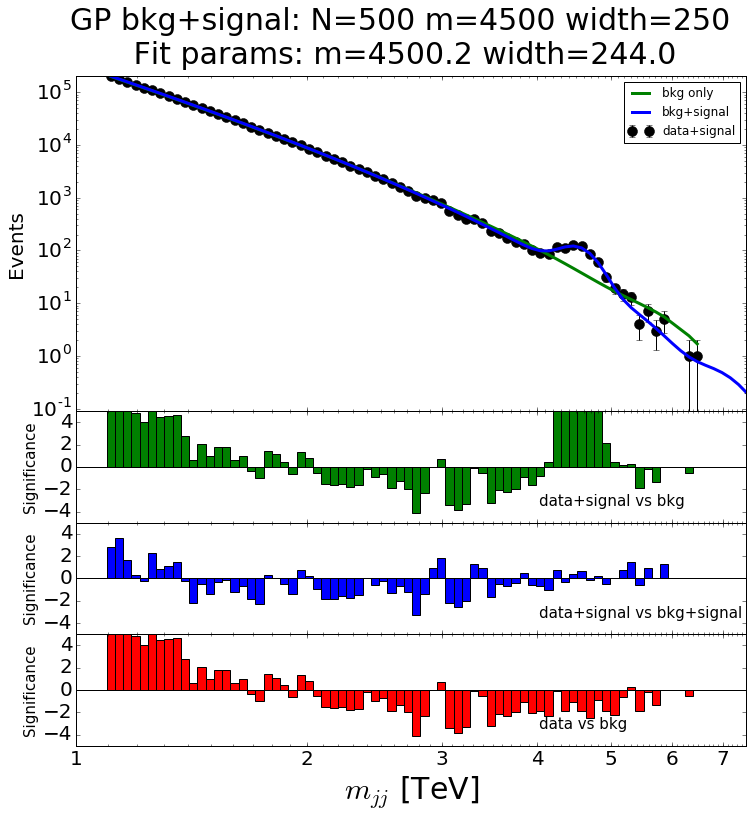

parameters (60, 5000, 250)
0
81 81 81
min LL 375.155010576
best fit vals (4999.999999985219, 2265.913744193508, 399.99999999291236)
A, mass, tau 4999.99999999 2265.91374419 399.999999993
chi2 bkg+signal mu=0 nan
chi2 bkg+signal 142.910692648
chi2 bkg+signal nan


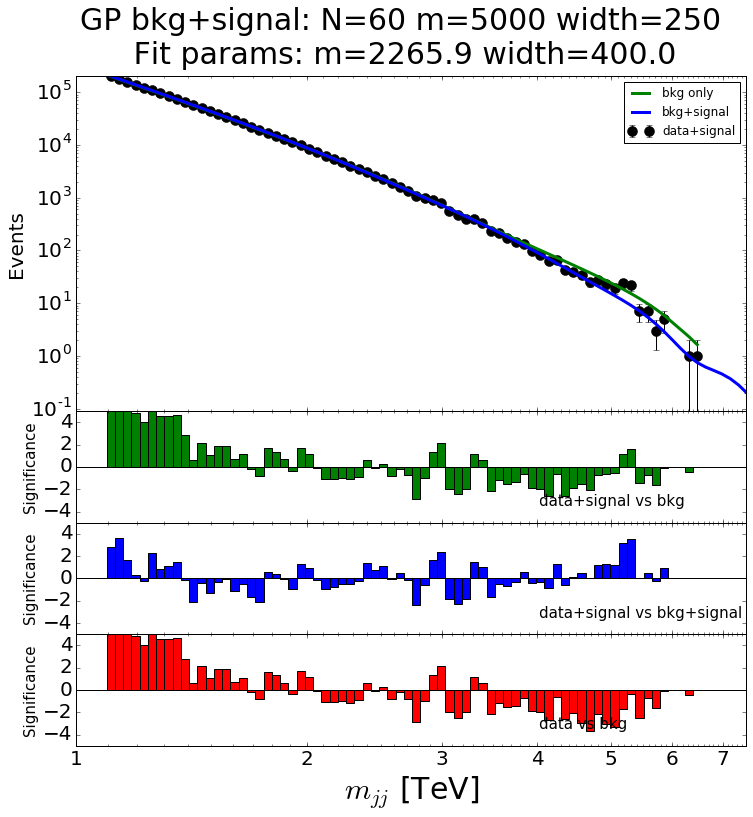

parameters (50, 5500, 250)
0
81 81 81
min LL 381.591842857
best fit vals (232.03384838442682, 5468.474025729416, 217.8905110069681)
A, mass, tau 232.033848384 5468.47402573 217.890511007


/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: divide by zero encountered in double_scalars


chi2 bkg+signal mu=0 nan
chi2 bkg+signal 135.401467852
chi2 bkg+signal nan


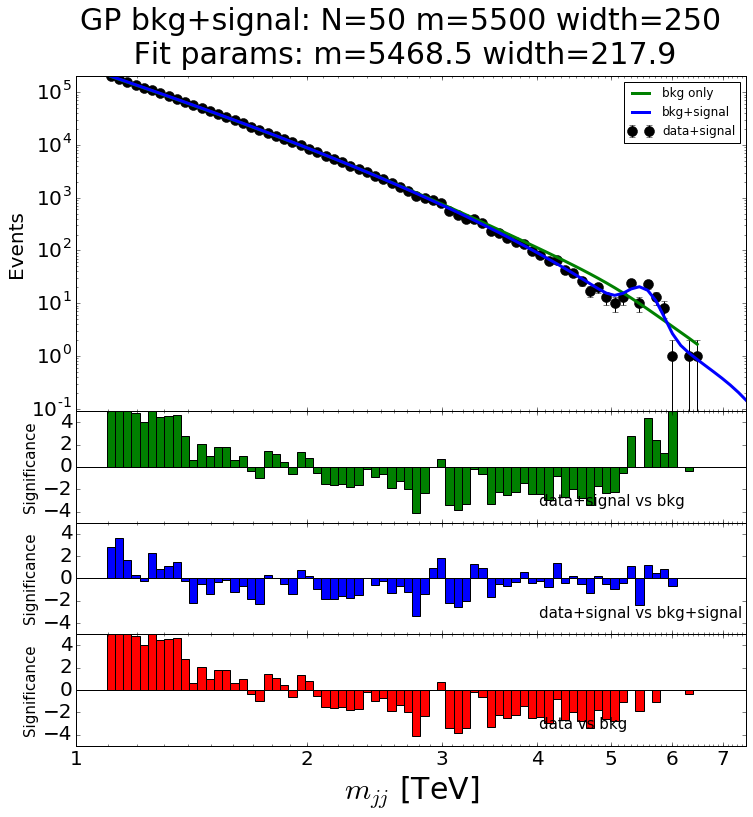

parameters (35, 6000, 250)
0
81 81 81
min LL 374.481387746
best fit vals (4999.998996053404, 2265.843012033078, 399.99999633545127)
A, mass, tau 4999.99899605 2265.84301203 399.999996335
chi2 bkg+signal mu=0 nan
chi2 bkg+signal 130.733351102
chi2 bkg+signal nan


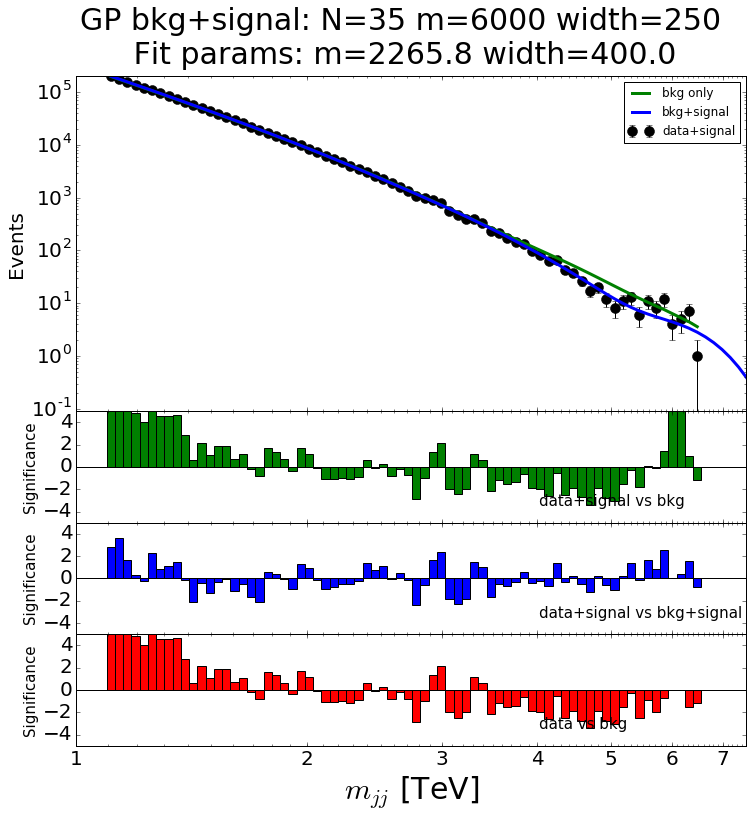

In [85]:
chi_GP_sig={}
chi_GP_bkg={}
chi_GP_sb={}

aa={}
mm={}
ww={}
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet

    chi_GP_sig[m]=[]
    chi_GP_bkg[m]=[]
    chi_GP_sb[m]=[]
    aa[m]=[]
    mm[m]=[]
    ww[m]=[]
    for itoy, toy in enumerate([ycounts]):#(toyData[:10]):
        if itoy%10 ==0: print itoy
        print len(xbins), len(toy),len(ycounts)
        ytoy, xtoy, xtoyerr = removeZeros(toy)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signalTemplate = sig_model(xtoy, n, m, w, xtoyerr)
        signalTemplate = np.random.poisson(np.around(signalTemplate))
        signalTemplate_full = sig_model(xbins, n, m, w, xerrs)
        signalTemplate_full = np.random.poisson(np.around(signalTemplate_full))
        
        ydata =  ytoy + signalTemplate
        ydata_full =  toy + signalTemplate_full
        
        Amp, length, p0, p1, p2 = fixedHyperP
        lnProb = logLike_gp_fitgpsig(xtoy, ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsig_minuit(lnProb, True)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau = best_fit_new 
        aa[m].append(A)
        mm[m].append(mass)
        ww[m].append(tau)
        print "A, mass, tau", A, mass, tau
        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        kernel1 = Amp * ExpSquaredKernel(length)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel, mean=Mean(p0=p0, p1=p1, p2=p2), fit_mean = True)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGP = gp.predict(ydata, xbins)[0]
        
        gp2 = george.GP(kernel, mean=Mean(p0=p0, p1=p1, p2=p2), fit_mean = True)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        mu1 = np.dot(K1, gp.solver.apply_inverse(ydata))+ model_gp((p0,p1, p2), xtoy, xtoyerr)
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        mu2 = np.dot(K2, gp.solver.apply_inverse(ydata))#-model_gp((p0,p1, p2), xbins, xerrs)))
        #mu1=meanGP-mu2
        newy, newx = addZeros(mu1, xtoy)
        
        #gp2 = george.GP(kernel2, mean=Mean(p0=p0, p1=p1, p2=p2), fit_mean = True)
        #gp2.compute(xbins, np.sqrt(ydata))
        #meanGP2 = gp2.predict(ydata, xbins)[0]
        
        #print meanGP2-meanGP
        
        #print mu1
        #print (mu2+mu1)-meanGP
        #print mu1-toy
        #print mu2-signalTemplate
        #zvalsig, chi2sig = calcSignificance(signalTemplate, mu2)
        #zvalsb, chi2sb = calcSignificance(ydata, meanGP)
        #zvalbkg, chi2bkg = calcSignificance(toy, mu1)
        #chi_GP_sig[m].append(chi2sig) 
        #chi_GP_sb[m].append(chi2sb) 
        #chi_GP_bkg[m].append(chi2bkg) 
        

        if itoy%10 ==0:
            label="GP bkg+signal: N="+str(n)+" m="+str(m)+" width="+str(w) + "\n Fit params:"+" m="+str(round(mass,1))+" width="+str(round(tau,1))
            makePrettyPlots_sb(xtoy, xbins, toy, ydata_full, newy, mu1, meanGP, binEdges, label)
            #makePrettyPlots_sb(xbins, ydata, toy, mu1, meanGP, binEdges, label)
            #makePrettyPlots_sb(xbins, ydata, toy, meanGP2, meanGP2, binEdges, "2")
    
        #label="Signal only: N="+str(n)+" m="+str(m)+" width="+str(w) + "\n Fit params:"+" m="+str(round(mass,1))+" width="+str(round(tau,1))
        #makePrettyPlots_signalOnly(xtoy, signalTemplate, mu2, label, n)
        

##### for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet
    print np.mean(aa[m]), np.mean(mm[m]), np.mean(ww[m])
    